In [28]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [29]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

Preparing a dataframe to summarize the dataset

In [30]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
306,negatives,50997651_67cc8c9939d74a9a_MG_L_CC_ANON.tif
58,positives,22678694_61b13c59bcba149e_MG_L_ML_ANON.tif
114,negatives,20587320_e634830794f5c1bd_MG_L_CC_ANON.tif
223,negatives,24065887_c01f83a1eb283270_MG_L_CC_ANON.tif
97,positives,53580858_51bec6477a7898b9_MG_L_CC_ANON.tif
111,negatives,20587200_fd746d25eb40b3dc_MG_R_ML_ANON.tif
6,positives,20587758_81cd83d2f4d78528_MG_L_CC_ANON.tif
367,negatives,53581264_80123a24997098dc_MG_R_CC_ANON.tif
100,positives,53582656_465aa5ec1b59efc6_MG_L_ML_ANON.tif
309,negatives,50997769_cbb6c98a81e69eeb_MG_R_ML_ANON.tif


Dataset Summary

In [31]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [32]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

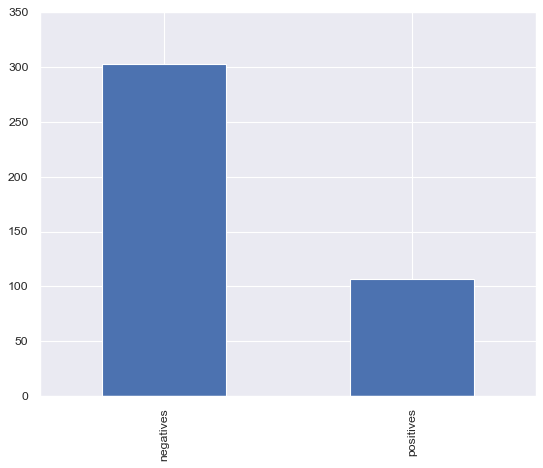

In [33]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

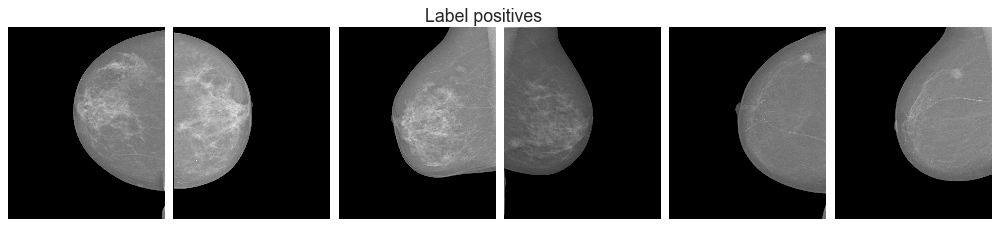

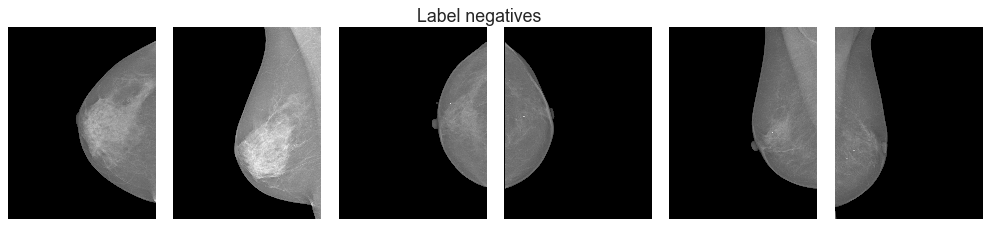

In [34]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

Resized Image Shape: (1331, 1024, 3)
Gray Image Shape: (1331, 1024)
Thresholded Mask Shape: (1331, 1024)


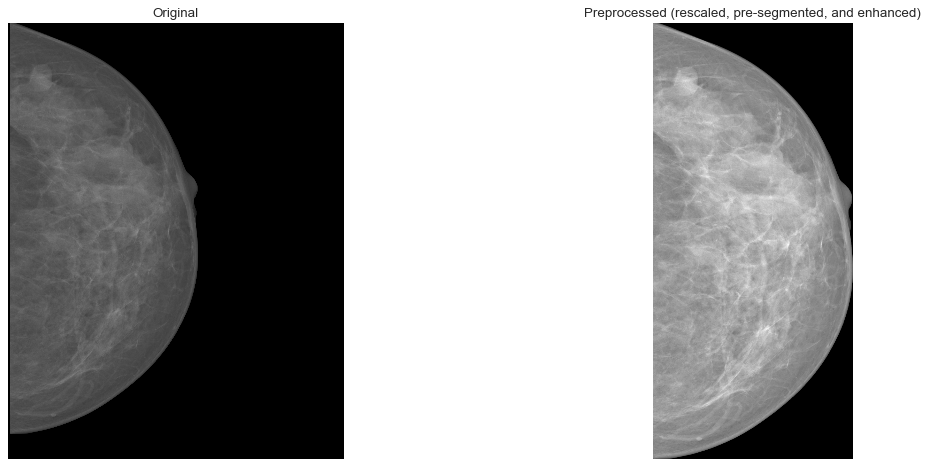

In [35]:
# Reading a single image
random_idx = random.randint(0,70)

img_name = os.listdir(os.path.join(dataset_folder_paths[0][1]))[random_idx]
img_path = os.path.join(dataset_folder_paths[1][1], img_name)

# original image
img = cv2.imread(
    img_path)

# 1. resizing image with a factor of 4 using INTER_CUBIC (bi-cubic) interpolation
scale_factor = 0.4
img_resized = cv2.resize(img.copy(), None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
print(f"Resized Image Shape: {img_resized.shape}")

img_gray = cv2.cvtColor(img_resized.copy(), cv2.COLOR_BGR2GRAY)
print(f"Gray Image Shape: {img_gray.shape}")


# 2. Pre-segmenting using thresholding technique and cropping redundant background
# https://stackoverflow.com/questions/63575738/remove-letter-artifacts-from-mammography-image
# The first argument is the source image, which should be a grayscale image. The second argument is 
# the threshold value which is used to classify the pixel values. The third argument is the maximum value
# which is assigned to pixel values exceeding the threshold. 
thresholding_mask = cv2.threshold(img_gray.copy(), 30, 255, cv2.THRESH_BINARY)[1]
print(f"Thresholded Mask Shape: {thresholding_mask.shape}")

# To remove redundant image, lets find the contours from the mask we generated
contours, _ = cv2.findContours(thresholding_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
contour_image = cv2.drawContours(img_gray.copy(), [largest_contour], -1, (255, 255, 255), 3)
cropped_image = img_gray.copy()[y:y+h, x:x+w]


# 3. Rescale (Normalize) the image to 16-bit unsigned integer (0-65535)
# Note, clahe expects 8-bit (0-255) not 16 ..
rescaled_img = cv2.normalize(cropped_image.copy(), None, 0, 255, cv2.NORM_MINMAX)


# 4. Applying CLAHE
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
clahe_img = clahe.apply(rescaled_img.copy())

imgs = {
    "Original": img, 
#     "Threshold Mask": thresholding_mask, 
#     "Contour on Gray Image": contour_image, 
#     "Cropped Image (Grayscale Version)": cropped_image, 
#     "Rescaled 16-bit":rescaled_img,
    "Preprocessed (rescaled, pre-segmented, and enhanced)": clahe_img
}

display.plot_figures(imgs, 1,2) 


2023-04-29 10:21:21.175 | INFO     | preprocessing:fit:70 - Started processing pipeline.
100%|███████████████████████████| 1/1 [00:00<00:00,  4.02it/s]
2023-04-29 10:21:21.431 | INFO     | preprocessing:fit:115 - Finished processing 410 files in approximately 0.256 seconds.


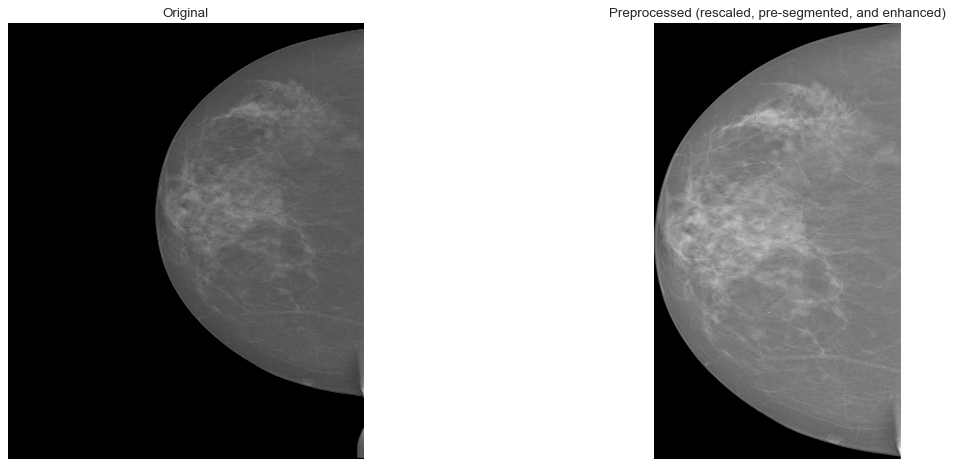

In [36]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], 
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

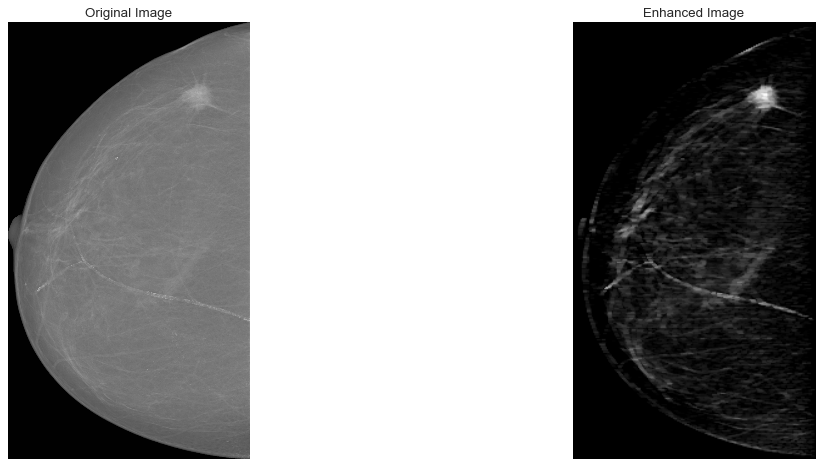

In [61]:
image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'

normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
    image_input_name, 
    plot=True,
)

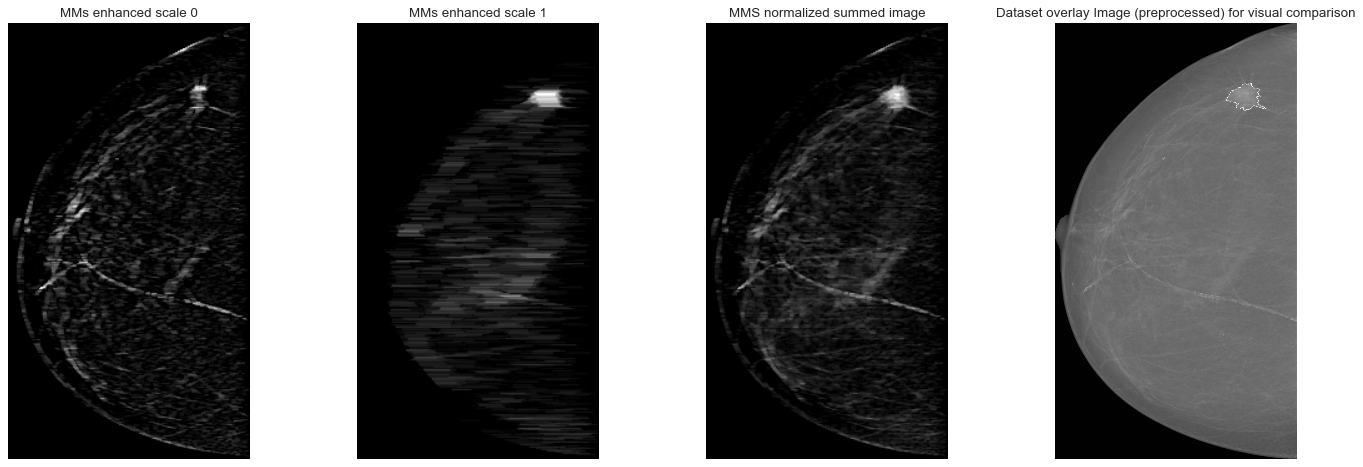

In [38]:
# Reading the same processed image (ovarlayed version) for visual comparison
overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
overlay_image = cv2.imread(overlay_image_dataset)

# Display the enhanced and tophat image
imgs = {
    "MMs enhanced scale 0": enhanced_images[0],
    "MMs enhanced scale 1": enhanced_images[1],
    "MMS normalized summed image": normalized_image,
    "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
}
display.plot_figures(imgs, 1, 4)

# Instead of MLO Thresholding
# superpixels - non-parametric approach
# k means clusturing - K levels
# means clusturing - reguarization params


# Features extraction
# GLCM features 10-15 + statistics of mass region (contrast average value)

# Shape features 10
# LBP 
# SIFTs

# Gabor wavelets ~ good to charectirize textures in iris


# Features reduction - LDA 

2. Multi-level Otsu thresholding

In [12]:
from typing import Tuple, List
from scipy.optimize import fmin

def otsu(image: np.ndarray, n: int):
    """
    This function performs multilevel Otsu thresholding on a 2D array.

    Otsu thresholding is a technique by which the optimal threshold is chosen so as to split a 2D array based on the
    peaks in its histogram.  In multilevel thresholding, we choose multiple optimal thresholds so that multiple peaks
    are separated.  This process is described in
    "Otsu N, A Threshold Selection Method from Gray-Level Histograms, IEEE Trans. Syst. Man Cybern. 1979;9:62-66."

    To use this function, simply input the image and the number of times you want to split the histogram.  The function
    will then return the optimal threshold values used to bin the image (n-1 thresholds), and a labeled image where each
    bin has its own number (n labels).  Note that the function will convert the image to a uint8 image if it is not
    already, and the thresholds will correspond to the uint8 image.

    This function uses the opencv threhold function to perform the thresholding when n=2 and is based off of the
    MATLAB function otsu
    (https://www.mathworks.com/matlabcentral/fileexchange/26532-image-segmentation-using-otsu-thresholding?s_tid=prof_contriblnk)
    for when n>=3.

    >>> import numpy
    >>> from giant.image_processing import otsu
    >>> from giant.point_spread_functions import Gaussian
    >>> im = numpy.zeros((100, 100), dtype=numpy.float64)
    >>> x, y = numpy.meshgrid(numpy.arange(10), numpy.arange(10))
    >>> psf = Gaussian(sigma_x=1.5, sigma_y=0.7, amplitude=100, centroid_x=5, centroid_y=5)
    >>> im[50:60, 50:60] = psf.evaluate(x, y)
    >>> thresh, labeled_im = otsu(im, 3)
    >>> print(thresh)
    [0.24723526470339388, 2.235294117647059]

    :param image: The grayscale image to be thresholded as a numpy array
    :param n: The number of times to bin the image (for a binary threshold n=2)
    :return: The n-1 threshold values and the labeled image with the background
             being labeled 0 and each subsequent bin being labeled with the next integer (ie 1, 2, 3, ...)
    """

    # convert the image to uint 8 (Assume it is already grayscale)
    if image.dtype != np.uint8:
        # noinspection PyArgumentList
        delta_conv = image.min()
        iu8 = image.astype(np.float64) - delta_conv
        multi_conv = 255 / iu8.max()
        iu8 = np.round(iu8 * multi_conv).astype(np.uint8)
    else:
        iu8 = image
        delta_conv = 0
        multi_conv = 1

    if n == 2:
        threshold, labeled_image = cv2.threshold(iu8, 0, 1, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

        threshold = float(threshold)
        threshold /= multi_conv
        threshold += delta_conv

        threshold = image.dtype.type(threshold)

        return [threshold], labeled_image

    else:
        # get the unique dn values at uint8 level
        unique_iu8 = np.unique(iu8.ravel())

        range_unique_image = np.arange(1, unique_iu8.size + 1)

        # generate a histogram of the values
        hist, _ = np.histogram(iu8, np.hstack([unique_iu8, [256]]))

        # estimate the pdf by scaling back so the integral is equal to 1
        pdf = hist / hist.sum()

        range_unique_image_pdf = range_unique_image * pdf

        if n == 3:

            # determine the zeroth and first-order cumulative moments
            w = pdf.cumsum()
            mu = range_unique_image_pdf.cumsum()

            w0 = w
            w2 = pdf[::-1].cumsum()[::-1]

            w0, w2 = np.meshgrid(w0, w2, indexing='ij')

            mu0 = mu / w

            mu2 = (range_unique_image_pdf[::-1].cumsum() / pdf[::-1].cumsum())[::-1]

            mu0, mu2 = np.meshgrid(mu0, mu2, indexing='ij')

            w1 = 1 - w0 - w2

            w1[w1 < 0] = np.nan

            mu0mue = mu0 - mu[-1]
            mu2mue = mu2 - mu[-1]
            w0mu0mue = w0 * mu0mue
            w2mu2mue = w2 * mu2mue

            sigma2b = w0mu0mue * mu0mue + w2mu2mue * mu2mue + (w0mu0mue + w2mu2mue) ** 2 / w1

            sigma2b[~np.isfinite(sigma2b)] = 0

            k = sigma2b.ravel().argmax()

            k1, k2 = np.unravel_index(k, sigma2b.shape)

            labeled_image = np.zeros(image.shape, dtype=np.float64)

            labeled_image[(iu8 > unique_iu8[k1]) & (iu8 <= unique_iu8[k2])] = 1

            labeled_image[iu8 > unique_iu8[k2]] = 2

            thresholds = np.array([unique_iu8[k1], unique_iu8[k2]], dtype=np.float64)

            thresholds /= multi_conv
            thresholds += delta_conv

            # noinspection PyTypeChecker
            out_thresh = thresholds.astype(image.dtype).tolist()  # type: list

            for ind, t in enumerate(out_thresh):
                out_thresh[ind] = min(max(t, image[labeled_image == ind].max()), image[labeled_image == ind+1].min())

            return out_thresh, labeled_image

        else:

            mut = range_unique_image_pdf.sum()
            sig2t = ((range_unique_image - mut) ** 2 * pdf).sum()

            def sig_fun(ik: np.ndarray) -> float:
                """
                A temporary function for passing to the optimizer

                :param ik:
                :return:
                """

                ik = np.round(ik * (unique_iu8.size - 1) + 1.000000000001)
                ik = np.sort(ik)

                if ((ik < 1) | (ik > unique_iu8.size)).any():
                    return 1

                ik = np.hstack([0, ik, unique_iu8.size]).astype(int)

                sigma2bi = 0

                for ii in range(n):
                    wj = pdf[ik[ii]:ik[ii + 1]].sum()

                    if wj == 0:
                        return 1

                    muj = (np.arange(ik[ii] + 1, ik[ii + 1] + 1) * pdf[ik[ii]:ik[ii + 1]]).sum() / wj
                    sigma2bi += wj * (muj - mut) ** 2

                return 1 - sigma2bi / sig2t

            k0 = np.linspace(0, 1, n + 1)[1:-1]

            kk = fmin(sig_fun, k0, xtol=1, disp=False)

            kk = np.round(kk * (unique_iu8.size - 1)).astype(int)

            labeled_image = np.zeros(image.shape, dtype=np.float64)

            labeled_image[iu8 > unique_iu8[kk[n - 2]]] = n - 1
            for i in range(n - 2):
                labeled_image[(iu8 > unique_iu8[kk[i]]) & (iu8 <= unique_iu8[kk[i + 1]])] = i + 1

            # put back into the original image values
            thresholds = unique_iu8[kk[:n - 2]].astype(np.float64)
            thresholds /= multi_conv
            thresholds += delta_conv

            # noinspection PyTypeChecker
            out_thresh = thresholds.astype(image.dtype).tolist()  # type: list

            for ind, t in enumerate(out_thresh):
                out_thresh[ind] = min(max(t, image[labeled_image == ind].max()), image[labeled_image == ind+1].min())

            return out_thresh, labeled_image

In [13]:
image = normalized_image.copy()

out_thresh, labeled_image = otsu(image, 15)
    

In [14]:
# Display the segmented image
cv2.imshow('labeled_image Image', labeled_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
import cv2
import numpy as np

def otsu_cv(image: np.ndarray, n: int):
    """
    This function performs multilevel Otsu thresholding on a 2D array.

    Otsu thresholding is a technique by which the optimal threshold is chosen so as to split a 2D array based on the
    peaks in its histogram.  In multilevel thresholding, we choose multiple optimal thresholds so that multiple peaks
    are separated.  This process is described in
    "Otsu N, A Threshold Selection Method from Gray-Level Histograms, IEEE Trans. Syst. Man Cybern. 1979;9:62-66."

    To use this function, simply input the image and the number of times you want to split the histogram.  The function
    will then return the optimal threshold values used to bin the image (n-1 thresholds), and a labeled image where each
    bin has its own number (n labels).  Note that the function will convert the image to a uint8 image if it is not
    already, and the thresholds will correspond to the uint8 image.

    This function uses the opencv threhold function to perform the thresholding when n=2 and is based off of the
    MATLAB function otsu
    (https://www.mathworks.com/matlabcentral/fileexchange/26532-image-segmentation-using-otsu-thresholding?s_tid=prof_contriblnk)
    for when n>=3.

    :param image: The grayscale image to be thresholded as a numpy array
    :param n: The number of times to bin the image (for a binary threshold n=2)
    :return: The n-1 threshold values and the labeled image with the background
             being labeled 0 and each subsequent bin being labeled with the next integer (ie 1, 2, 3, ...)
    """

    # convert the image to uint 8 (Assume it is already grayscale)
    if image.dtype != np.uint8:
        # noinspection PyArgumentList
        delta_conv = image.min()
        iu8 = image.astype(np.float64) - delta_conv
        multi_conv = 255 / iu8.max()
        iu8 = np.round(iu8 * multi_conv).astype(np.uint8)
    else:
        iu8 = image
        delta_conv = 0
        multi_conv = 1

    if n == 2:
        threshold, labeled_image = cv2.threshold(iu8, 0, 1, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

        threshold = float(threshold)
        threshold /= multi_conv
        threshold += delta_conv

        threshold = image.dtype.type(threshold)

        return [threshold], labeled
  


In [18]:
image = normalized_image.copy()

out_thresh, labeled_image = otsu_cv(image, 15)

# Display the segmented image
cv2.imshow('labeled_image Image', labeled_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: cannot unpack non-iterable NoneType object

In [27]:
# Region Candidate Generation
image = normalized_image.copy()
len_bank = LSE_magnitudes
candidates = []

# convert the image to uint 8 (Assume it is already grayscale)
if image.dtype != np.uint8:
    # noinspection PyArgumentList
    delta_conv = image.min()
    iu8 = image.astype(np.float64) - delta_conv
    multi_conv = 255 / iu8.max()
    iu8 = np.round(iu8 * multi_conv).astype(np.uint8)
else:
    iu8 = image
    delta_conv = 0
    multi_conv = 1
    
image = iu8

for scale in range(1, 3):
#     img_dilated = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (len_bank[scale], len_bank[scale])))
#     img_eroded = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (len_bank[scale], len_bank[scale])))
#     img_scale = cv2.absdiff(img_dilated, img_eroded)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        if 30 <= w <= 200 and 30 <= h <= 200:  # target size range
            candidates.append((x * 4, y * 4, w * 4, h * 4))  # scale up

print(candidates)

# Inspect applying multi-level otsu thresholding within the scale loop before summing or normalizing 
# as in here - https://chat.openai.com/c/7eed323b-f99d-4660-99bc-0e66534dd056

[(84, 664, 668, 528), (124, 180, 608, 528), (84, 664, 668, 528), (124, 180, 608, 528)]


In [21]:
# Show image with region candidates
for candidate in candidates:
    x, y, w, h = candidate
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
cv2.imshow('Region Candidates', image)
cv2.waitKey(0)




-1

In [ ]:
# from skimage.filters import threshold_multiotsu

# # Generate a random 16-bit image
# img = enhanced_image.copy()

# # Perform multi-Otsu thresholding with 2 scales and 16 levels
# thresholds = threshold_multiotsu(img, 2, 512)

# # Apply the thresholds to the image
# seg = np.digitize(img, bins=thresholds)

# # Plot the result
# import matplotlib.pyplot as plt
# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
# ax0.imshow(img, cmap='gray')
# ax0.set_title('Original')
# ax1.imshow(seg, cmap='gray')
# ax1.set_title('Segmented')
# plt.show()





In [36]:

# # Scale the image values from 0 to 255 (8-bit)
# enhanced_image = ((enhanced_image - np.min(enhanced_image)) * 255 / (np.max(enhanced_image) - np.min(enhanced_image))).astype(np.uint8)

# # Calculate the threshold values using multi-level Otsu thresholding
# thresholds = cv2.threshold_multiotsu(enhanced_image, 5)

# # Segment the image into six regions based on the calculated threshold values
# regions = np.zeros_like(enhanced_image)
# for i in range(len(thresholds)):
#     if i == 0:
#         regions[enhanced_image <= thresholds[i]] = i
#     elif i == len(thresholds) - 1:
#         regions[enhanced_image > thresholds[i-1]] = i
#     else:
#         regions[(enhanced_image > thresholds[i-1]) & (enhanced_image <= thresholds[i])] = i

# # Display the segmented image
# cv2.imshow('Segmented Image', regions.astype(np.uint8)*50)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [12]:
# from skimage import io, filters

# # Calculate three threshold values using Multi-level Otsu thresholding
# thresholds = filters.threshold_multiotsu(enhanced_image, classes=16)




In [13]:
# # Segment the image into four regions based on the calculated threshold values
# regions = np.digitize(enhanced_image, bins=thresholds)


# io.imshow(regions)
# io.show()


In [14]:
# # Normalize the enhanced image to 8-bit
# enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# # Define the number of scales
# num_scales = 2

# # Define the number of bins
# K = 16

# # Compute the global Otsu threshold
# _, global_threshold = cv2.threshold(enhanced_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Initialize the threshold vector
# thresholds = [global_threshold]

# # Compute the thresholds at each scale
# for i in range(num_scales):
#     # Compute the histogram
#     hist = cv2.calcHist([enhanced_image], [0], None, [K], [0, 65536])

#     # Compute the threshold using Otsu's method
#     _, threshold = cv2.threshold(enhanced_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # Store the threshold in the threshold vector
#     thresholds.append(threshold)
    
#     print(threshold[0])

#     # Apply the threshold to the enhanced image
#     enhanced_image = cv2.bitwise_and(enhanced_image, cv2.threshold(enhanced_image, threshold[0], 255, cv2.THRESH_BINARY)[1])

# # Plot the contours of the segmentation on the original image
# contours = cv2.findContours(enhanced_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
# cv2.drawContours(enhanced_image, contours, -1, (0, 255, 0), 2)
# cv2.imshow('Segmented Image', enhanced_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [15]:
# # Convert the image to an 8-bit grayscale image
# img_8bit = cv2.convertScaleAbs(enhanced_image, alpha=(255.0/65535.0))

# # Apply Otsu thresholding
# _, thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Display the thresholded image
# cv2.imshow('Thresholded Image', thresh)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [16]:
# # Set the number of thresholds
# K = 16
# # enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# # Calculate the Otsu thresholds
# _, max_val = cv2.threshold(enhanced_image, 0, 65535, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresholds = [i * max_val / (K + 1) for i in range(1, K + 1)]

# # Apply multi-level thresholding
# segmented_images = []
# for i in range(1, K):
#     t = cv2.threshold(enhanced_image, 0, 65535, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
#     thresholds.append(t)
#     _, binary_image = cv2.threshold(enhanced_image, t, 65535, cv2.THRESH_BINARY)
#     segmented_images.append(binary_image)
    

# # # Apply size thresholding
# # filtered_images = []
# # for binary_image in segmented_images:
# #     binary_image = binary_image.astype('uint8')
# #     # Find connected components
# #     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

# #     # Filter out small components
# #     for i in range(1, num_labels):
# #         if stats[i, cv2.CC_STAT_AREA] < 100:  # Adjust this value to change the size threshold
# #             binary_image[labels == i] = 0

# #     filtered_images.append(binary_image)



In [17]:

# # display.plot_figures(imgs, 1,2) 
# # # 
# for i in range(len(segmented_images)):
#     plt.axis('off')
#     plt.imshow(segmented_images[i])
#     plt.show()


In [18]:
# # imgs = {
# #     "enhanced_image": enhanced_image,
# #     "filtered_images": filtered_images
# # }

# # display.plot_figures(imgs, 1,2) 
# # # 
# for i in range(len(filtered_images)):
#     plt.axis('off')
#     plt.imshow(filtered_images[i])
#     plt.show()

    

In [19]:
# plt.axis('off')
# plt.imshow(enhanced_image, cmap='gray')


In [20]:
# # Define the scales for multi-scale morphological sifting
# scales = range(1, 5)

# enhanced_image = enhanced_image.astype('uint8')

# # Perform multi-scale morphological sifting for each scale
# for scale in scales:
#     # Apply mean shift filtering
# #     shifted = cv2.pyrMeanShiftFiltering(enhanced_image, scale, scale)
    
#     # Perform 16-level multi-level Otsu thresholding
#     _, thresh = cv2.threshold(shifted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV, 16)
    
#     # Find contours for each threshold level and draw them on the original image
#     contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     for i in range(len(contours)):
#         cv2.drawContours(img, contours, i, (0, 0, 255), 2)
